In [ ]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard


In [ ]:
import os
print(os.listdir("C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/"))
from glob import glob
from pathlib import Path
import shutil
from tqdm import tqdm_notebook
from random import sample, choice

['.ipynb_checkpoints', '16 filt - Copie.ipynb', 'best_weights.h5', 'class_dict.csv', 'logs', 'Nouveau dossier', 'test', 'test_labels', 'top-weights.h5', 'train', 'train_labels', 'val', 'val_labels']


In [ ]:
dataset_path = Path("C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/")
list(dataset_path.iterdir())

[WindowsPath('C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/.ipynb_checkpoints'),
 WindowsPath('C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/16 filt - Copie.ipynb'),
 WindowsPath('C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/best_weights.h5'),
 WindowsPath('C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/class_dict.csv'),
 WindowsPath('C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/logs'),
 WindowsPath('C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/Nouveau dossier'),
 WindowsPath('C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/test'),
 WindowsPath('C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/test_labels'),
 WindowsPath('C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/top-weights.h5'),
 WindowsPath('C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/train'),
 WindowsPath('C:/Users/maste/OneDrive/Bureau/segmentation a

In [ ]:
def tree(directory):
    print(f'+ {directory}')
    for path in sorted(directory.rglob('*')):
        depth = len(path.relative_to(directory).parts)
        spacer = '    ' * depth
        print(f'{spacer}+ {path.name}')   

In [ ]:
train_imgs = list((dataset_path / "train").glob("*.png"))
train_labels = list((dataset_path / "train_labels").glob("*.png"))
val_imgs = list((dataset_path / "val").glob("*.png"))
val_labels = list((dataset_path / "val_labels").glob("*.png"))
test_imgs = list((dataset_path / "test").glob("*.png"))
test_labels = list((dataset_path / "test_labels").glob("*.png"))

(len(train_imgs),len(train_labels)), (len(val_imgs),len(val_labels)) , (len(test_imgs),len(test_labels))

img_size = 512

In [ ]:
assert len(train_imgs) == len(train_labels), "No of Train images and label mismatch"
assert len(val_imgs) == len(val_labels), "No of Train images and label mismatch"
assert len(test_imgs) == len(test_labels), "No of Train images and label mismatch"

sorted(train_imgs), sorted(train_labels), sorted(val_imgs), sorted(val_labels), sorted(test_imgs), sorted(test_labels);

In [ ]:
for im in train_imgs:
    assert dataset_path / "train_labels" / (im.stem +"_L.png") in train_labels , "{im} noht there in label folder"
for im in val_imgs:
    assert dataset_path / "val_labels" / (im.stem +"_L.png") in val_labels , "{im} not there in label folder"
for im in test_imgs:
    assert dataset_path / "test_labels" / (im.stem +"_L.png") in test_labels , "{im} not there in label folder"

In [ ]:
def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , dataset / label / (im.stem +"_L.png")))
    
    return pairs

In [ ]:
train_pair = make_pair(train_imgs, "train_labels", dataset_path)
val_pair = make_pair(val_imgs, "val_labels", dataset_path)
test_pair = make_pair(test_imgs, "test_labels", dataset_path)

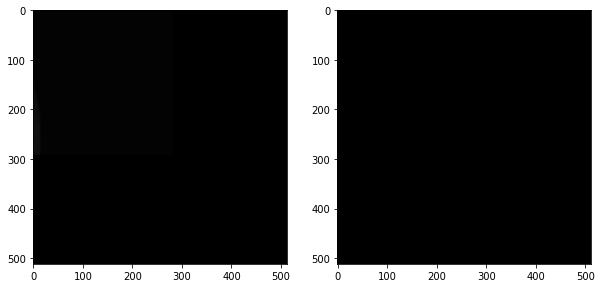

In [ ]:
temp = choice(train_pair)
img = img_to_array(load_img(temp[0], target_size=(img_size,img_size)))
mask = img_to_array(load_img(temp[1], target_size = (img_size,img_size)))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

In [ ]:
class_map_df = pd.read_csv(dataset_path / "class_dict.csv", sep=r'\s*,\s*',
                           header=0, encoding='ascii', engine='python')
print(class_map_df.columns.tolist())

['name', 'r', 'g', 'b']


In [ ]:
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))
    
len(class_map)

4

In [ ]:
def assert_map_range(mask,class_map):
    mask = mask.astype("uint8")
    
    
    
    for j in range(img_size):
        for k in range(img_size):
            assert mask[j][k] in class_map , tuple(mask[j][k])

In [ ]:
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    
    return label

In [ ]:
lab = form_2D_label(mask,class_map)
np.unique(lab,return_counts=True)

(array([1], dtype=uint8), array([262144], dtype=int64))

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair, class_map, batch_size=16, dim=(img_size,img_size,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = to_categorical(label , num_classes = 4)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

In [ ]:
train_generator = DataGenerator(train_pair,class_map,batch_size=16, dim=(img_size,img_size,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

720

In [ ]:
X,y = train_generator.__getitem__(1)
y.shape

(16, 512, 512, 4)

In [ ]:
val_generator = DataGenerator(val_pair, class_map, batch_size=16, dim=(img_size,img_size,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

90

In [ ]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(img_size, img_size, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv2 = conv_block(conv1, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    ################################
    conv3 = conv_block(conv1_out, nfilters=filters*2)
    conv4 = conv_block(conv3, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    ########################################################
    conv5 = conv_block(conv2_out, nfilters=filters*4)
    conv6 = conv_block(conv5, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv6)
    #############################################################
    conv7 = conv_block(conv3_out, nfilters=filters*8)
    conv8 = conv_block(conv7, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv8)
    conv4_out = Dropout(0.3)(conv4_out)
    #######################################################
    conv9 = conv_block(conv4_out, nfilters=filters*16)
    conv10 = conv_block(conv9, nfilters=filters*16)
    conv11 = Dropout(0.3)(conv10)
    #changer DO 0.3 0.5 0.75
# up
    deconv6 = deconv_block(conv11, residual=conv8, nfilters=filters*8)
    deconv6 = Dropout(0.3)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv6, nfilters=filters*4)
    deconv7 = Dropout(0.3)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv4, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv2, nfilters=filters)
    output_layer = Conv2D(filters=4, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [ ]:
model = Unet(img_size,img_size, 32)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [ ]:
import tensorflow as tf
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
model.compile(optimizer = Adam(learning_rate = 0.00001
), loss = ['categorical_crossentropy'], metrics = ['accuracy',precision, recall])
 
#model.compile(optimizer='adam',(lr = 0.01), loss='categorical_crossentropy' ,  metrics = ['accuracy',precision, recall])


In [ ]:
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='loss',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='accuracy', patience=10, verbose=0)
tb = TensorBoard(log_dir="logs/", histogram_freq=0, write_graph=True, write_images=False)
#rl = ReduceLROnPlateau(monitor='accuracy',factor=0.1 ,patience=5,verbose=1,mode="max",min_lr=0.01)
cv = CSVLogger("logs/log.csv" , append=True , separator=',')
lr = 0.01


In [ ]:
results = model.fit_generator(train_generator , steps_per_epoch=train_steps , epochs=150,
                              validation_data=val_generator,validation_steps=val_steps,callbacks=[mc,es,tb,cv])

C:\Users\maste\AppData\Local\Temp/ipykernel_7456/1128431050.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_generator , steps_per_epoch=train_steps , epochs=150,


Epoch 1/150
720/720 [==============================] - ETA: 0s - loss: 0.7679 - accuracy: 0.9032 - precision: 0.9549 - recall: 0.5752
Epoch 00001: loss improved from -inf to 0.76792, saving model to top-weights.h5
720/720 [==============================] - 424s 571ms/step - loss: 0.7679 - accuracy: 0.9032 - precision: 0.9549 - recall: 0.5752 - val_loss: 0.5229 - val_accuracy: 0.9860 - val_precision: 0.9919 - val_recall: 0.9477
Epoch 2/150
720/720 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.9909 - precision: 0.9929 - recall: 0.9730
Epoch 00002: loss did not improve from 0.76792
720/720 [==============================] - 404s 561ms/step - loss: 0.3896 - accuracy: 0.9909 - precision: 0.9929 - recall: 0.9730 - val_loss: 0.3396 - val_accuracy: 0.9921 - val_precision: 0.9932 - val_recall: 0.9834
Epoch 3/150
720/720 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.9930 - precision: 0.9935 - recall: 0.9883
Epoch 00003: loss did not improve fro

Epoch 22/150
720/720 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9944 - precision: 0.9947 - recall: 0.9941
Epoch 00022: loss did not improve from 0.76792
720/720 [==============================] - 404s 561ms/step - loss: 0.0298 - accuracy: 0.9944 - precision: 0.9947 - recall: 0.9941 - val_loss: 0.0257 - val_accuracy: 0.9944 - val_precision: 0.9946 - val_recall: 0.9942
Epoch 23/150
720/720 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9944 - precision: 0.9947 - recall: 0.9941
Epoch 00023: loss did not improve from 0.76792
720/720 [==============================] - 403s 560ms/step - loss: 0.0285 - accuracy: 0.9944 - precision: 0.9947 - recall: 0.9941 - val_loss: 0.0244 - val_accuracy: 0.9944 - val_precision: 0.9950 - val_recall: 0.9938
Epoch 24/150
720/720 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9944 - precision: 0.9948 - recall: 0.9940
Epoch 00024: loss did not improve from 0.76792
720/720 [===========

Epoch 43/150
720/720 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9945 - precision: 0.9948 - recall: 0.9943
Epoch 00043: loss did not improve from 0.76792
720/720 [==============================] - 404s 561ms/step - loss: 0.0197 - accuracy: 0.9945 - precision: 0.9948 - recall: 0.9943 - val_loss: 0.0176 - val_accuracy: 0.9945 - val_precision: 0.9949 - val_recall: 0.9941
Epoch 44/150
720/720 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9945 - precision: 0.9948 - recall: 0.9943
Epoch 00044: loss did not improve from 0.76792
720/720 [==============================] - 405s 562ms/step - loss: 0.0196 - accuracy: 0.9945 - precision: 0.9948 - recall: 0.9943 - val_loss: 0.0174 - val_accuracy: 0.9945 - val_precision: 0.9949 - val_recall: 0.9941
Epoch 45/150
720/720 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9946 - precision: 0.9948 - recall: 0.9943
Epoch 00045: loss did not improve from 0.76792
720/720 [===========

Epoch 64/150
720/720 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9947 - precision: 0.9948 - recall: 0.9946
Epoch 00064: loss did not improve from 0.76792
720/720 [==============================] - 405s 562ms/step - loss: 0.0174 - accuracy: 0.9947 - precision: 0.9948 - recall: 0.9946 - val_loss: 0.0161 - val_accuracy: 0.9945 - val_precision: 0.9948 - val_recall: 0.9943
Epoch 65/150
720/720 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9947 - precision: 0.9948 - recall: 0.9946
Epoch 00065: loss did not improve from 0.76792
720/720 [==============================] - 404s 560ms/step - loss: 0.0174 - accuracy: 0.9947 - precision: 0.9948 - recall: 0.9946 - val_loss: 0.0154 - val_accuracy: 0.9946 - val_precision: 0.9948 - val_recall: 0.9944
Epoch 66/150
720/720 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9947 - precision: 0.9948 - recall: 0.9946
Epoch 00066: loss did not improve from 0.76792
720/720 [===========

Epoch 85/150
720/720 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9949
Epoch 00085: loss did not improve from 0.76792
720/720 [==============================] - 404s 561ms/step - loss: 0.0162 - accuracy: 0.9950 - precision: 0.9950 - recall: 0.9949 - val_loss: 0.0161 - val_accuracy: 0.9947 - val_precision: 0.9948 - val_recall: 0.9945
Epoch 86/150
720/720 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9950 - precision: 0.9951 - recall: 0.9949
Epoch 00086: loss did not improve from 0.76792
720/720 [==============================] - 404s 561ms/step - loss: 0.0161 - accuracy: 0.9950 - precision: 0.9951 - recall: 0.9949 - val_loss: 0.0151 - val_accuracy: 0.9947 - val_precision: 0.9949 - val_recall: 0.9945
Epoch 87/150
720/720 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9950 - precision: 0.9951 - recall: 0.9949
Epoch 00087: loss did not improve from 0.76792
720/720 [===========

Epoch 106/150
720/720 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9952 - precision: 0.9953 - recall: 0.9952
Epoch 00106: loss did not improve from 0.76792
720/720 [==============================] - 405s 561ms/step - loss: 0.0154 - accuracy: 0.9952 - precision: 0.9953 - recall: 0.9952 - val_loss: 0.0176 - val_accuracy: 0.9947 - val_precision: 0.9948 - val_recall: 0.9946
Epoch 107/150
720/720 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9952 - precision: 0.9953 - recall: 0.9952
Epoch 00107: loss did not improve from 0.76792
720/720 [==============================] - 404s 561ms/step - loss: 0.0152 - accuracy: 0.9952 - precision: 0.9953 - recall: 0.9952 - val_loss: 0.0146 - val_accuracy: 0.9948 - val_precision: 0.9949 - val_recall: 0.9947
Epoch 108/150
720/720 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9952 - precision: 0.9953 - recall: 0.9952
Epoch 00108: loss did not improve from 0.76792
720/720 [========

Epoch 127/150
720/720 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9954 - precision: 0.9955 - recall: 0.9954
Epoch 00127: loss did not improve from 0.76792
720/720 [==============================] - 404s 561ms/step - loss: 0.0147 - accuracy: 0.9954 - precision: 0.9955 - recall: 0.9954 - val_loss: 0.0144 - val_accuracy: 0.9948 - val_precision: 0.9950 - val_recall: 0.9947
Epoch 128/150
720/720 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9954 - precision: 0.9955 - recall: 0.9954
Epoch 00128: loss did not improve from 0.76792
720/720 [==============================] - 405s 562ms/step - loss: 0.0146 - accuracy: 0.9954 - precision: 0.9955 - recall: 0.9954 - val_loss: 0.0189 - val_accuracy: 0.9947 - val_precision: 0.9948 - val_recall: 0.9946
Epoch 129/150
720/720 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9954 - precision: 0.9955 - recall: 0.9954
Epoch 00129: loss did not improve from 0.76792
720/720 [========

Epoch 148/150
720/720 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9955
Epoch 00148: loss did not improve from 0.76792
720/720 [==============================] - 405s 562ms/step - loss: 0.0142 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9955 - val_loss: 0.0147 - val_accuracy: 0.9949 - val_precision: 0.9950 - val_recall: 0.9947
Epoch 149/150
720/720 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956
Epoch 00149: loss did not improve from 0.76792
720/720 [==============================] - 404s 561ms/step - loss: 0.0141 - accuracy: 0.9956 - precision: 0.9956 - recall: 0.9956 - val_loss: 0.0144 - val_accuracy: 0.9949 - val_precision: 0.9951 - val_recall: 0.9948
Epoch 150/150
720/720 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9956 - precision: 0.9957 - recall: 0.9956
Epoch 00150: loss did not improve from 0.76792
720/720 [========

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


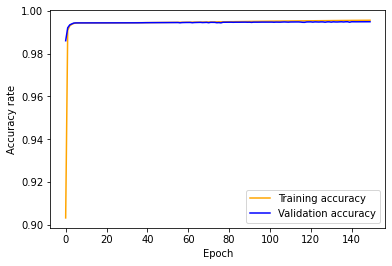

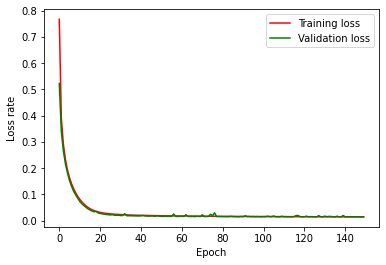

In [ ]:
print(results.history.keys())
from matplotlib import pyplot as plt
plt.figure()
plt.plot(results.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(results.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy rate')
plt.legend()
plt.show()

plt.figure()
plt.plot(results.history['loss'], 'red', label='Training loss')
plt.plot(results.history['val_loss'], 'green', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss rate')
plt.legend()
plt.show()

In [ ]:
img_mask = choice(val_pair)
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

In [ ]:
def make_prediction(model,img_path,shape):
    img= img_to_array(load_img(img_path , target_size= shape))/255.
    img = np.expand_dims(img,axis=0)
    labels = model.predict(img)
    labels = np.argmax(labels[0],axis=2)
    return labels

In [ ]:
pred_label = make_prediction(model, img_mask[0], (img_size,img_size,3))
pred_label.shape

(512, 512)

In [ ]:
def form_colormap(prediction,mapping):
    h,w = prediction.shape
    color_label = np.zeros((h,w,3),dtype=np.uint8)    
    color_label = mapping[prediction]
    color_label = color_label.astype(np.uint8)
    return color_label

In [ ]:
pred_colored = form_colormap(pred_label,np.array(class_map))

Text(0.5, 1.0, 'predicted labels')

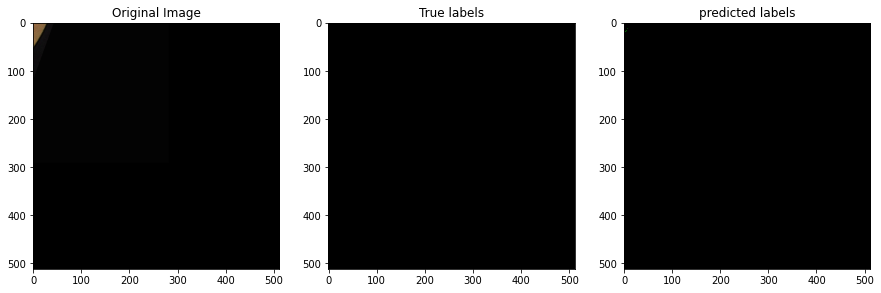

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')

In [ ]:
from matplotlib import cm
import os
from PIL import Image

PATH = "C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/test/"
Copy_to_path="C:/Users/maste/OneDrive/Bureau/segmentation a-v code/09-02-2022/Nouveau dossier/"

for filename in os.listdir(PATH):
    img_mask = Image.open(os.path.join(PATH, filename))
    print(filename)
    pred_label = make_prediction(model, os.path.join(PATH, filename), (img_size,img_size,3))
    pred_colored = form_colormap(pred_label,np.array(class_map))
    plt.imsave(os.path.join(Copy_to_path, filename), pred_colored)

img1.png
img10.png
img100.png
img1000.png
img1001.png
img1002.png
img1003.png
img1004.png
img1005.png
img1006.png
img1007.png
img1008.png
img1009.png
img101.png
img1010.png
img1011.png
img1012.png
img1013.png
img1014.png
img1015.png
img1016.png
img1017.png
img1018.png
img1019.png
img102.png
img1020.png
img1021.png
img1022.png
img1023.png
img1024.png
img1025.png
img1026.png
img1027.png
img1028.png
img1029.png
img103.png
img1030.png
img1031.png
img1032.png
img1033.png
img1034.png
img1035.png
img1036.png
img1037.png
img1038.png
img1039.png
img104.png
img1040.png
img1041.png
img1042.png
img1043.png
img1044.png
img1045.png
img1046.png
img1047.png
img1048.png
img1049.png
img105.png
img1050.png
img1051.png
img1052.png
img1053.png
img1054.png
img1055.png
img1056.png
img1057.png
img1058.png
img1059.png
img106.png
img1060.png
img1061.png
img1062.png
img1063.png
img1064.png
img1065.png
img1066.png
img1067.png
img1068.png
img1069.png
img107.png
img1070.png
img1071.png
img1072.png
img1073.png
img10

img342.png
img343.png
img344.png
img345.png
img346.png
img347.png
img348.png
img349.png
img35.png
img350.png
img351.png
img352.png
img353.png
img354.png
img355.png
img356.png
img357.png
img358.png
img359.png
img36.png
img360.png
img361.png
img362.png
img363.png
img364.png
img365.png
img366.png
img367.png
img368.png
img369.png
img37.png
img370.png
img371.png
img372.png
img373.png
img374.png
img375.png
img376.png
img377.png
img378.png
img379.png
img38.png
img380.png
img381.png
img382.png
img383.png
img384.png
img385.png
img386.png
img387.png
img388.png
img389.png
img39.png
img390.png
img391.png
img392.png
img393.png
img394.png
img395.png
img396.png
img397.png
img398.png
img399.png
img4.png
img40.png
img400.png
img401.png
img402.png
img403.png
img404.png
img405.png
img406.png
img407.png
img408.png
img409.png
img41.png
img410.png
img411.png
img412.png
img413.png
img414.png
img415.png
img416.png
img417.png
img418.png
img419.png
img42.png
img420.png
img421.png
img422.png
img423.png
img424.pn

In [ ]:
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

In [ ]:
model.save_weights("best_weights.h5")

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy',recall,precision])
model.load_weights("best_weights.h5")

In [ ]:
val_hist = model.evaluate(val_generator, steps = len(val_generator), verbose = 1)

90/90 [==============================] - 36s 389ms/step - loss: 0.0144 - accuracy: 0.9949 - recall_1: 0.9948 - precision_1: 0.9951
